In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import concat
import seaborn as sns
import timeit
import warnings
from statistics import stdev, variance

from tensorflow import keras 
from CoolProp.CoolProp import PropsSI
from CoolProp.CoolProp import HAPropsSI


sns.set_theme()
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={"figure.figsize": (16, 20)})

# Some IPython magic to remove  the need to invoke show after each plot
%matplotlib inline

warnings.filterwarnings("ignore")

Remove outliers where there are unrealistic readings where probes may have been damaged.

In [3]:
df = pd.read_csv("data/freezer_room.csv")
df.dropna(inplace=True)
df = df.drop(df[(df["Air Temp"] > 20) | (df["Air Temp"] < -30)].index)


Tidy up some variables

In [4]:
df["unit"] = df.unit.apply(lambda u: u[-8:])
df["date_time"] = pd.to_datetime(df["timestamp"], unit="s")
df.sort_values(by="date_time", inplace=True)
df["year"] = df["date_time"].dt.year
df["month"] = df["date_time"].dt.month
df["cabinet"] = "Freezer Room"
df["Differential"] = pd.to_numeric(df["Differential"])

Get the absolute difference between the airtemt and differential

In [5]:
df["actual_diff"] = df["Set Point"] - df["Air Temp"]
df["actual_diff"] = df.actual_diff.apply(lambda x: abs(x))

Make variables numeric types

In [6]:
df["Air Temp"] = pd.to_numeric(df["Air Temp"])
df["Evaporator"] = pd.to_numeric(df["Evaporator"])
df["actual_diff"] = pd.to_numeric(df["actual_diff"])

Shift row values to get 30 minute blocks

In [7]:
df["t+05"] = df["Air Temp"].shift(-1)
df["t+10"] = df["Air Temp"].shift(-2)
df["t+15"] = df["Air Temp"].shift(-3)
df["t+20"] = df["Air Temp"].shift(-4)
df["t+25"] = df["Air Temp"].shift(-5)
df["t+30"] = df["Air Temp"].shift(-6)

df["e+05"] = df["Evaporator"].shift(-1)
df["e+10"] = df["Evaporator"].shift(-2)
df["e+15"] = df["Evaporator"].shift(-3)
df["e+20"] = df["Evaporator"].shift(-4)
df["e+25"] = df["Evaporator"].shift(-5)
df["e+30"] = df["Evaporator"].shift(-6)

Take 1 month as a sample

In [8]:
jan_2017 = df[(df["year"] > 2017) & (df["month"] > 1)]
jan_2017.dropna(inplace=True)
# jan_2017


In [9]:
jan_2017["std_dev_temp"]=jan_2017[["Air Temp","t+05","t+10","t+15","t+20","t+25","t+30"]].std( axis=1)

jan_2017["std_dev_evap"]=jan_2017[["Air Temp","e+05","e+10","e+15","e+20","e+25","e+30"]].std( axis=1)


jan_2017["variance_temp"]=jan_2017[["Air Temp","t+05","t+10","t+15","t+20","t+25","t+30"]].var( axis=1)

jan_2017["variance_evap"]=jan_2017[["Air Temp","e+05","e+10","e+15","e+20","e+25","e+30"]].var( axis=1)





In [21]:
def is_defrost(lst, fall=False):
    if fall:
        lst = lst[::-1]
    return sorted(lst) == lst



In [27]:
jan_2017["defrost_rise"] = df.apply(
    lambda row: is_defrost(
        [
            row["Air Temp"],
            row["t+05"],
            row["t+10"],
            row["t+15"],
            row["t+20"],
            row["t+25"],
            row["t+30"],
        ]
    ),
    axis=1,
)

The time difference for a is : 11.603229366010055
The time difference for b is is : 11.687948271021014


In [14]:
jan_2017["defrost_fall"] = df.apply(
    lambda row: is_defrost(
        [
            row["Air Temp"],
            row["t+05"],
            row["t+10"],
            row["t+15"],
            row["t+20"],
            row["t+25"],
            row["t+30"],
        ],
        True,
    ),
    axis=1,
)



In [18]:
jan_2017["defrot_fall1"].equals(jan_2017["defrost_fall2"]), jan_2017["defrost_rise1"].equals(jan_2017["defrost_rise2"])

(True, True)

In [13]:

jan_2017["peak"] = df.apply(
    lambda row: max(
        [
            row["Air Temp"],
            row["t+05"],
            row["t+10"],
            row["t+15"],
            row["t+20"],
            row["t+25"],
            row["t+30"],
        ],
      
    ),
    axis=1,
)


# jan_2017["peakl"] = df.apply(
#     lambda row: is_defrost(
        
        
#         max([
#             row["Air Temp"],
#             row["t+05"],
#             row["t+10"],
#             row["t+15"],
#             row["t+20"],
#             row["t+25"],
#             row["t+30"],
#         ],
#         )
#     ),
#     axis=1,
# )


In [ ]:
max([1,2,3,4,5
    ])

lst=[1,2,3,4,5
    ]
# lst=lst.reverse()
lst
lst[::-1]

In [36]:
defrost = jan_2017[(jan_2017.defrost_rise == True) | (jan_2017.defrost_fall == True)]
# defrost
defrost_up = jan_2017[jan_2017.defrost_rise == True]
defrost_down = jan_2017[jan_2017.defrost_fall == True]
defrost4 = jan_2017[jan_2017.Differential == 4]
defrost3 = jan_2017[jan_2017.Differential == 3]

<AxesSubplot:xlabel='Evaporator', ylabel='Air Temp'>

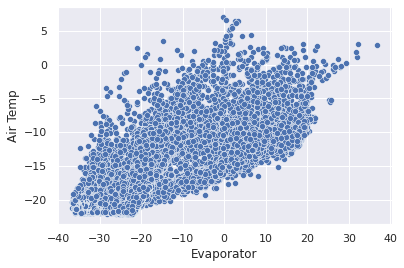

In [38]:
sns.scatterplot(
    data=defrost4,
    x="Evaporator",
    y="Air Temp",
#     hue="Differential",
    
#     height=10,
#     aspect=0.6,
)

<AxesSubplot:xlabel='Evaporator', ylabel='Air Temp'>

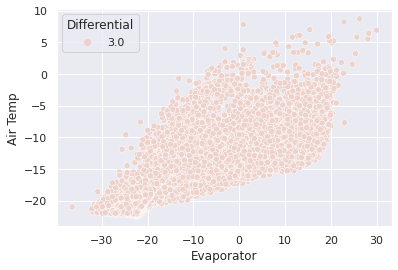

In [40]:
sns.scatterplot(
    data=defrost3,
    x="Evaporator",
    y="Air Temp",
    hue="Differential",
    
#     height=10,
#     aspect=0.6,
)

<AxesSubplot:xlabel='Evaporator', ylabel='Air Temp'>

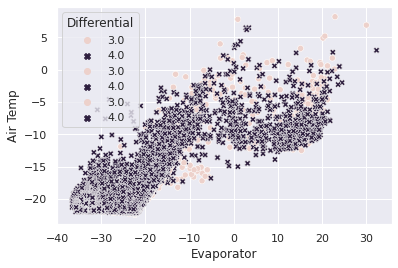

In [34]:
sns.color_palette("hls", 8)
sns.scatterplot(
    data=defrost,
    x="Evaporator",
    y="Air Temp",
    hue="Differential",
       style="Differential",
#     height=10,
#     aspect=0.6,
)
sns.scatterplot(
    data=defrost_up,
    x="Evaporator",
    y="Air Temp",
    hue="Differential",
       style="Differential",
#     height=10,
#     aspect=0.6,
)
sns.scatterplot(
    data=defrost_down,
    x="Evaporator",
    y="Air Temp",
    hue="Differential",
       style="Differential",
#     height=10,
#     aspect=0.6,
)

<AxesSubplot:xlabel='Evaporator', ylabel='Air Temp'>

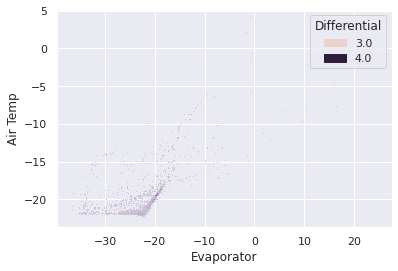

In [26]:
sns.histplot(data=defrost_up, x='Evaporator', y='Air Temp' ,hue='Differential')

In [ ]:
sns.histplot(data=defrost_down, x='Evaporator', y='Air Temp')

In [ ]:
sns.histplot(data=jan_2017, x='std_dev_temp', y='Air Temp', hue='Differential')

In [ ]:
sns.lineplot(data=jan_2017, x='std_dev_evap', y='Air Temp')

In [ ]:
sns.lineplot(data=jan_2017, x='variance_temp', y='Air Temp')

<AxesSubplot:xlabel='variance_evap', ylabel='Air Temp'>

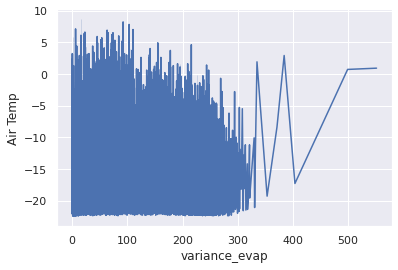

In [41]:
sns.lineplot(data=jan_2017, x='variance_evap', y='Air Temp')

In [ ]:
jan_2017 = df[(df["year"] > 2017) & (df["month"] > 1)]

df[['date_time','Air Temp','t+05','t+10','e+05','Evaporator']]

In [ ]:
# def isDefrost(row):
#   pass
df.dropna(inplace=True)
df

In [ ]:
df.columns
# df["std_dev_temp"] = df.apply(lambda row:  stdev([row['t+05'], row['t+10']]))

In [ ]:
df["std_dev_temp"] = df.apply(lambda row:  stdev([row['t+05'], row['t+10'],
                                                  row['t+15'], row['t+20'],
                                                  row['t+25'], row['t+30']]),axis = 1)


In [ ]:
df["variance_temp"] = df.apply(lambda row:  variance([row['t+05'], row['t+10'],
                                                  row['t+15'], row['t+20'],
                                                  row['t+25'], row['t+30']]),axis = 1)

In [ ]:
df["std_dev_evap"] = df.apply(lambda row:  stdev([row['e+05'], row['e+10'],
                                                  row['e+15'], row['e+20'],
                                                  row['e+25'], row['e+30']]),axis = 1)

In [ ]:
df["variance_evap"] = df.apply(lambda row:  variance([row['e+05'], row['e+10'],
                                                  row['e+15'], row['e+20'],
                                                  row['e+25'], row['e+30']]),axis = 1)

In [ ]:
sns.lineplot(data=df, x='variance_evap', y='variance_temp')

In [ ]:
sns.histplot(data=df, x='variance_evap', y='variance_temp')

In [ ]:
sns.histplot(data=df, x='date_time', y='variance_temp', hue='Air Temp' )

In [ ]:
sns.displot(df, x="Air Temp", bins=30)

In [ ]:
sns.displot(df, x="variance_evap", bins=30)

In [ ]:
sns.displot(df, x="std_dev_evap", bins=30)

In [ ]:



def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
            data: Sequence of observations as a list or NumPy array.
            n_in: Number of lag observations as input (X).
            n_out: Number of observations as output (y).
            dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
            Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
agg=series_to_supervised(df, n_in=10, n_out=10, dropnan=True)


In [ ]:
agg

In [ ]:
diff_four = df[df["Differential"] == 4]
diff_three = df[df["Differential"] == 3]
_diff4=diff_four[['Differential','Evaporator','Set Point','Air Temp','actual_diff']]

In [ ]:
sns.pairplot(
    _diff4,
    plot_kws={"alpha": 0.6, "s": 80, "edgecolor": "k"},
    hue="Air Temp",
    height=4,
    diag_kind="hist",
)
# plt.show()

In [ ]:
sns.pairplot(diff_three[['Evaporator','Air Temp']])

In [ ]:
sns.pairplot(diff_three[['Differential','Evaporator','Set Point','Air Temp','actual_diff']])

In [ ]:
plt.plot(jan_2017["Air Temp"], label="Actual")
plt.ylabel("Air Temp")
plt.xlabel("Data")
plt.title("Actual Data")

In [ ]:
jan_2017
sns.pairplot(jan_2017)


In [ ]:
sns.pairplot(df[['Differential','Evaporator','Set Point','Air Temp','actual_diff']])

In [ ]:
sns.pairplot(df)

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pylab as plt

# cols = ['how_long', 'state', 'user', 'when_start']
# data = [[62297, 'FINISHED', 'xavi', 1499963793923],
#  [25761, 'FINISHED', 'xavi', 1499963446385],
#  [20082, 'FINISHED', 'xavi', 1499963221203],
#  [20508, 'FINISHED', 'xavi', 1499963156760],
#  [580975, 'FINISHED', 'xavi', 1499962435293]]

# apps_pd = pd.DataFrame(data, columns = cols)
# # convert ms timestamps of dataframe to date time format by pandas
# #apps_pd['when_start'] = pd.to_datetime(apps_pd['when_start'], unit='ms')
# print (apps_pd)

sns.lmplot(x="date_time", y="Air Temp", hue="month", data=jan_2017, lowess=True)

# get current axis
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
# convert all xtick labels to selected format from ms timestamp
ax.set_xticklabels(
    [pd.to_datetime(tm, unit="ms").strftime("%Y-%m-%d\n %H:%M:%S") for tm in xticks],
    rotation=50,
)

plt.show()

In [ ]:
df

In [ ]:
sea = sns.FacetGrid(jan_2017, row="Air Temp", col="date_time", margin_titles=True)

sea.map(sns.regplot, "id", "pulse", color=".3", fit_reg=False, x_jitter=0.1)

In [ ]:
df
sea = sns.FacetGrid(df, row="Air Temp", col="date_time", margin_titles=True)

sea.map(sns.regplot, "id", "pulse", color=".3", fit_reg=False, x_jitter=0.1)

In [ ]:
sns.pairplot(df, hue="Set Point")

In [ ]:
sns.boxplot(x="Air Temp", y="Evaporator", data=pd.melt(df))

In [ ]:
# sns.lineplot(data=data_preproc)
# sns.lineplot(x='date_time', y='value', hue='variable',
#              data=pd.melt(data_preproc, ['Year']))
# df2 = df.melt('date_time', var_name='cols',  value_name='vals')
# g = sns.catplot(x="date_time", y="vals", hue='cols', data=df2, kind='line')
# sns.relplot(x='weight',
#             y='horsepower',
#             data=cars,
#             kind='scatter',
#             size='displacement',
#             hue='acceleration');

sns.relplot(
    y="Air Temp",
    x="date_time",
    data=df,
    size="displacement",
    hue="acceleration",
    palette="crest",
    col="origin",
)

sns.relplot(y="Air Temp", x="date_time", data=df, hue="Evaporator", kind="line")

In [ ]:


df['t+05'] = df['Air Temp'].shift(-1)
df['t+10'] = df['Air Temp'].shift(-2)
df['t+15'] = df['Air Temp'].shift(-3)
df['t+20'] = df['Air Temp'].shift(-4)
df['t+25'] = df['Air Temp'].shift(-5)
df['t+30'] = df['Air Temp'].shift(-5)
